# Setting up offshore wind farm layout
## For HFM FY2022 Q4 Milestone

### Small case with 8 turbines

In [1]:
# Note: this python notebook was automatically generated by make_tutorial3.py

# Load the amrwind-frontend module
amrwindfedir = '/projects/wind_uq/lcheung/amrwind-frontend'  # Location of amrwind-frontend 
import sys, os
sys.path.insert(1, amrwindfedir)

# Load the libraries
import amrwind_frontend  as amrwind
import matplotlib.pyplot as plt
import numpy             as np
import math

# Also ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Make all plots inline 
%matplotlib inline

**Note**: Make sure to have the IEA15 Reference wind turbine defined somewhere by amrwind-frontend.  For instance in the `turbines/` subdirectory, create a YAML file with the contents:

In [2]:
with open(amrwindfedir+"/turbines/IEA15MW.yaml")as f: print(f.read())

turbines:
  IEA15MW_Joukowski:     # This is an arbitrary, unique name
    turbinetype_name:    "IEA15MW_Joukowsky"
    turbinetype_comment: "Dummy layout"   # arbitrary
    Actuator_type:                JoukowskyDisk
    Actuator_rotor_diameter:      240
    Actuator_hub_height:          150     # Double-check
    Actuator_output_frequency:    10                   
    # --------------------
    Actuator_diameters_to_sample: 5.0     # How far upstream to sample inflow wind
    #Actuator_epsilon:             [5.0]   # Epsilon in Z (might need to play with this guy)
    Actuator_num_points_r:        40      # number of radial (might need to play with this guy)
    Actuator_num_points_t:        5       # number of pts in theta (might need to play with this guy)
    #Actuator_vortex_core_size:    24.0    # might need to play with this
    # --------------------
    # These will come from
    # https://github.com/IEAWindTask37/IEA-15-240-RWT/blob/master/performance/performance_ccblade.dat


### Define turbine and farm properties

In [3]:
# Define some properties
rotorD = 240           # Rotor diameter
WS     = 9             # Wind speed, m/s
WDir   = 200           # Wind direction, degrees

# Farm properties
#farm_rotate      = -30                          # Number of degrees to rotate turbine rows (relative to x-axis)
farm_domainsize  = [6400.0, 6400.0, 1920.0]   # Farm domain size
farm_center      = [0, 0]
farm_background_mesh = 10.0                     # Background mesh size [meters]

In [4]:
# Start the AMR-Wind case
case = amrwind.MyApp.init_nogui()

In [5]:
case.setAMRWindInput('useWSDir', True)
case.setAMRWindInput('ABL_windspeed', WS, forcechange=True)
case.setAMRWindInput('ABL_winddir',   WDir, forcechange=True)
case.ABL_calculateWindVector()

In [6]:
# Some random stuff
case.setAMRWindInput('incflo.physics', ['FreeStream', 'Actuator'])
case.setAMRWindInput('time.fixed_dt', 0.25)

In [7]:
# Original turbine locations
turbxy=[
    [-169.7056275, -1527.350647],
    [-848.5281374, -848.5281374],
    [-1527.350647, -169.7056275],
    [339.411255, -339.411255],
    [-339.411255, 339.411255],
    [1527.350647, 169.7056275],
    [848.5281374, 848.5281374],
    [169.7056275, 1527.350647],
]
turboffset=[-500,-500]
farmturb_xy = [np.array(xy)+np.array(turboffset) for xy in turbxy]

In [8]:
# Build the CSV input file of turbine layouts for amrwind-frontend
turbinescsv="""
# CSV file should have columns with
# name, x, y, type, yaw, hubheight, options
"""
rowformat="T%02i, %f, %f, IEA15MW_Joukowsky, , ,\n"
for iturb, xy in enumerate(farmturb_xy):
    turbinescsv += rowformat%(iturb, xy[0], xy[1])
case.setAMRWindInput('turbines_csvtextbox',  turbinescsv)

In [9]:
# Set up the domain 
case.setAMRWindInput('turbines_domainsize', farm_domainsize)
case.setAMRWindInput('turbines_backgroundmeshsize', farm_background_mesh)
case.setAMRWindInput('turbines_deleteprev', True)
case.setAMRWindInput('turbines_autocalccenter', False)
case.setAMRWindInput('turbines_farmcenter', [0,0], forcechange=True)

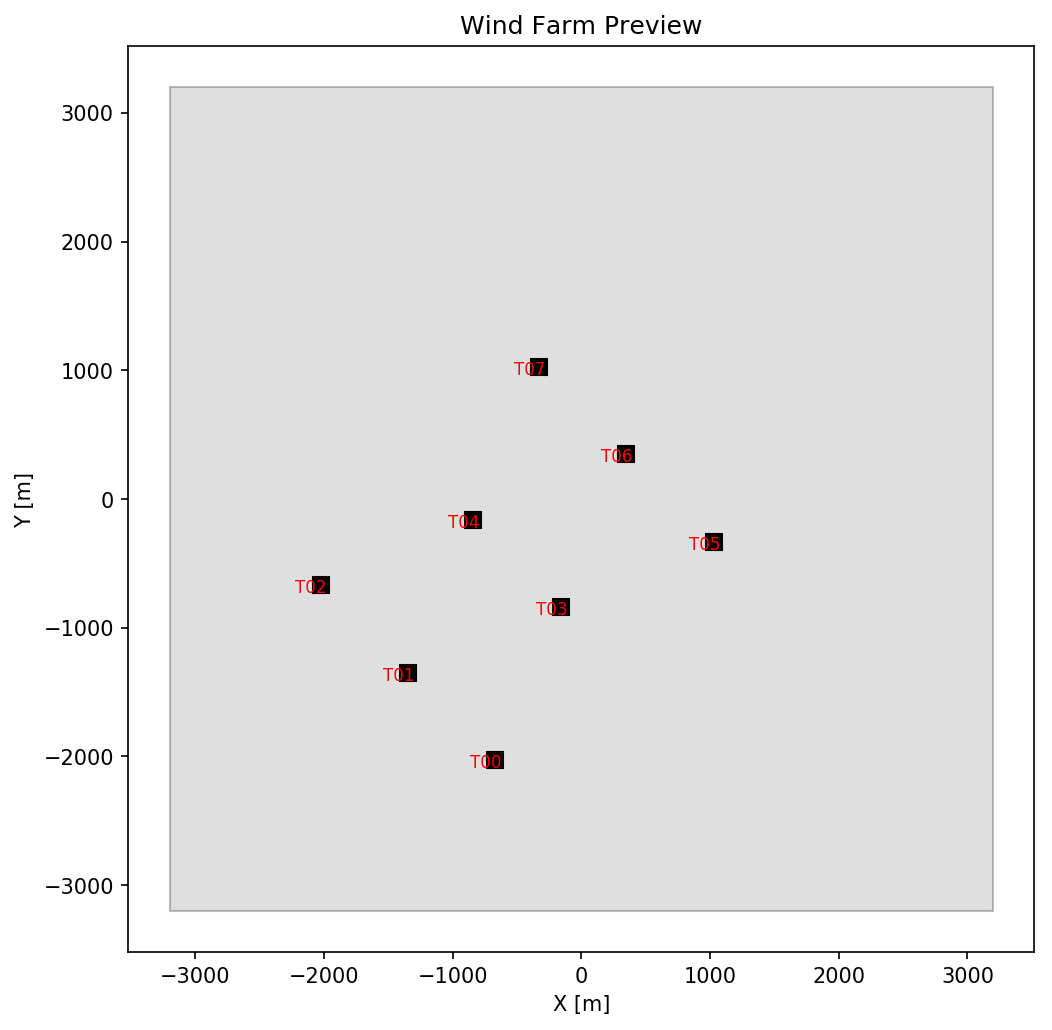

In [10]:
# Preview the turbine layout
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.turbines_previewAllTurbines(ax=ax)

In [11]:
case.turbines_createAllTurbines()

# Print out existing list of turbines, just to confirm that the turbines got made
print(case.listboxpopupwindict['listboxactuator'].getitemlist())

CANNOT update: ABLMeanBoussinesq use forcechange=True in setval()
['T00', 'T01', 'T02', 'T03', 'T04', 'T05', 'T06', 'T07']


## Create refinement windows

In [12]:
refinementcsv="""
# CSV file should have columns with
# level, upstream, downstream, lateral, below, above, options
level, upstream, downstream, lateral, below, above, options
0,     1.25,     1.25,       1.25, 0.525, 0.525, orientation:y
"""
case.setAMRWindInput('refine_csvtextbox', refinementcsv)
case.setAMRWindInput('refine_deleteprev', True)

In [13]:
case.refine_createAllZones()
# Print out existing list of turbines
#print(case.listboxpopupwindict['listboxtagging'].getitemlist())

Plotting turbines


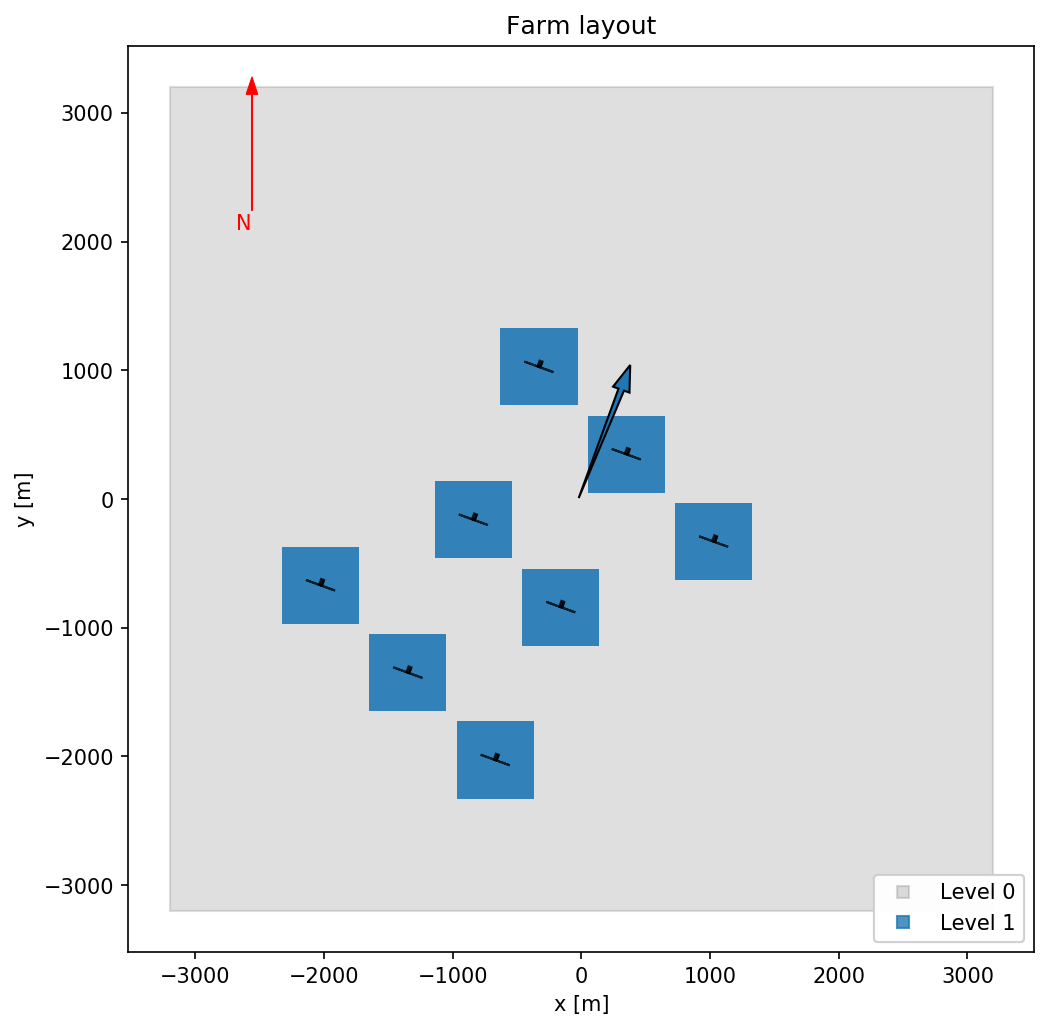

In [14]:
# Plot the domain (total domain)
fig, ax = plt.subplots(figsize=(8,8), facecolor='w', dpi=150)
case.popup_storteddata['plotdomain']['plot_turbines']        = case.listboxpopupwindict['listboxactuator'].getitemlist()
case.popup_storteddata['plotdomain']['plot_refineboxes']     = case.listboxpopupwindict['listboxtagging'].getitemlist()
case.popup_storteddata['plotdomain']['plot_windnortharrows'] = True
case.plotDomain(ax=ax)
ax.axis('scaled')
#ax.set_xlim([-10000,10000])
#ax.set_ylim([-10000,10000])
ax.set_title('Farm layout')

In [15]:
# Estimate mesh size
case.estimateMeshSize()

Refinement T00_level_0_zone: level 1: 725760 cells
Refinement T01_level_0_zone: level 1: 725760 cells
Refinement T02_level_0_zone: level 1: 725760 cells
Refinement T03_level_0_zone: level 1: 725760 cells
Refinement T04_level_0_zone: level 1: 725760 cells
Refinement T05_level_0_zone: level 1: 725760 cells
Refinement T06_level_0_zone: level 1: 725760 cells
Refinement T07_level_0_zone: level 1: 725760 cells
ESTIMATED MESH SIZE
   Level       Ncells                      Cell Size
       0     78643200             10.0 x 10.0 x 10.0
       1      5806080                5.0 x 5.0 x 5.0
  TOTAL:     84449280
